In [2]:
import logging

import matplotlib.pyplot as plt
import numpy as np

from mkidreadoutanalysis.mkidnoiseanalysis import plot_channel_fft, plot_psd, apply_lowpass_filter, compute_r
from mkidreadoutanalysis.resonator import *
from mkidreadoutanalysis.mkidnoiseanalysis import plot_psd
from mkidreadoutanalysis.mkidreadout import MKIDReadout
from mkidreadoutanalysis.optimal_filters.make_filters import Calculator
from mkidreadoutanalysis.optimal_filters.config import ConfigThing
import copy
%matplotlib inline

# Import Data

In [68]:
data = np.load(f'/work/jpsmith/Gen3/Fridge_Tests/r_testing/data/white_fridge/10_18_23/wf_ellison3_6000_650GHz.npz')

dark_phase=data['dark_phase']
dark_iq=data['dark_iq'] 
ir_phase=data['ir_phase']
ir_iq=data['ir_iq']
red_phase=data['red_phase']
red_iq=data['red_iq']
blue_phase=data['blue_phase']
blue_iq=data['blue_iq']

# Raw Data

## Red Data

### FPGA Phase

#### Set Threshold and Deadtime

In [3]:
red_phase_readout = MKIDReadout()
red_phase_readout.trigger(red_phase, fs = 1e6, threshold=-0.15, deadtime=30)
print(f'Total photons: {(red_phase_readout.trig>0).sum()}')

Total photons: 22381


#### Triggered Phase Timestream

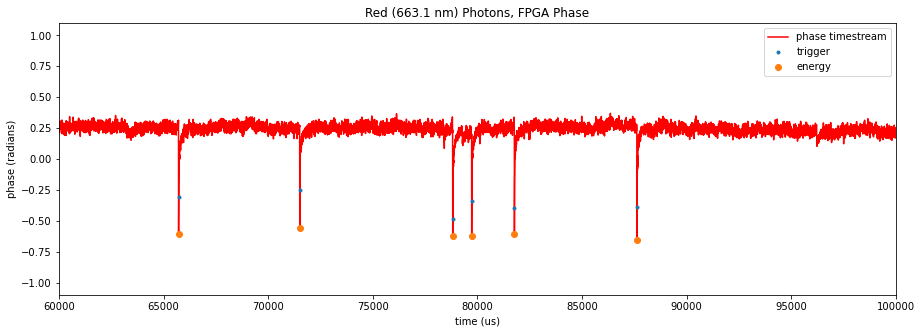

In [4]:
red_phase_readout.plot_triggers(red_phase, fs=1e6, energies=True, color='red')
plt.xlim([60000,100000]);
plt.title('Red (663.1 nm) Photons, FPGA Phase');

## Get Dark Level

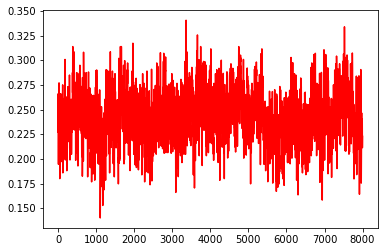

In [53]:
x = slice(10000, 18000)
plt.plot(red_phase[x], color='red')
red_phase_dark_mean = red_phase[x].mean()

#### Phase Histogram

Max Phase: -0.8821381173690578 FWHM: 0.06094268945730974 radians


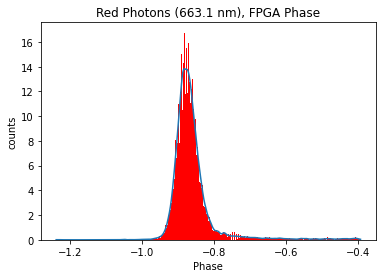

In [67]:
red_phase_max_location, red_phase_fwhm = compute_r(red_phase_readout.photon_energies - red_phase_dark_mean, color='red', plot=True)
print(f'Max Phase: {-red_phase_max_location} FWHM: {red_phase_fwhm} radians')
plt.title('Red Photons (663.1 nm), FPGA Phase');

### FPGA IQ --> Phase

#### Set Threshold and Deadtime

In [6]:
red_iq_readout = MKIDReadout()
red_iq_phase = np.angle(red_iq)
red_iq_readout.trigger(red_iq_phase, fs = 1e6, threshold=0.25, deadtime=60)
print(f'Total photons: {(red_iq_readout.trig>0).sum()}')

Total photons: 11059


#### Triggered Phase Timestream

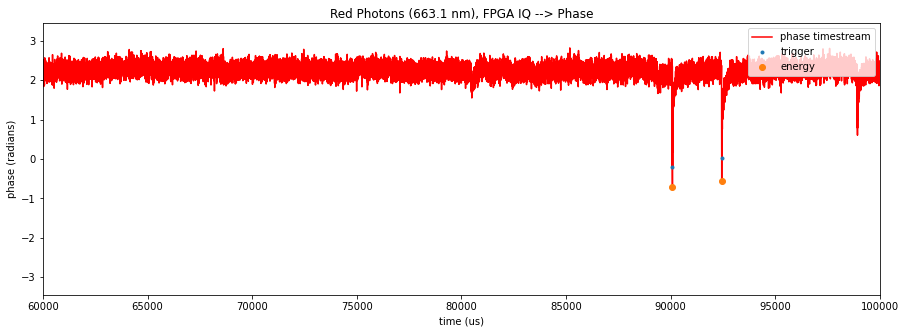

In [7]:
red_iq_readout.plot_triggers(red_iq_phase, fs=1e6, energies=True, color='red')
plt.xlim([60000,100000]);
plt.title('Red Photons (663.1 nm), FPGA IQ --> Phase');

## Get Dark Level

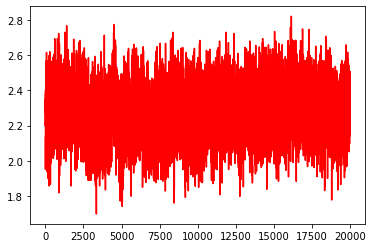

In [54]:
x = slice(10000, 30000)
plt.plot(red_iq_phase[x], color='red')
red_iq_dark_mean = red_iq_phase[x].mean()

#### Phase Histogram

Max Phase: -2.9193591207362166 FWHM: 0.2800585374560325 radians


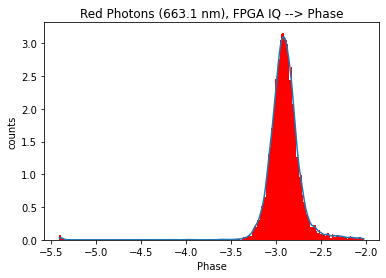

In [66]:
red_iq_max_location, red_iq_fwhm = compute_r(red_iq_readout.photon_energies - red_iq_dark_mean, color='red', plot=True)
print(f'Max Phase: {-red_iq_max_location} FWHM: {red_iq_fwhm} radians')
plt.title('Red Photons (663.1 nm), FPGA IQ --> Phase');

## IR Data

### FPGA Phase

#### Set Threshold and Deadtime

In [9]:
ir_phase_readout = MKIDReadout()
ir_phase_readout.trigger(ir_phase, fs = 1e6, threshold=-0.15, deadtime=30)
print(f'Total photons: {(ir_phase_readout.trig>0).sum()}')

Total photons: 31178


#### Triggered Phase Timestream

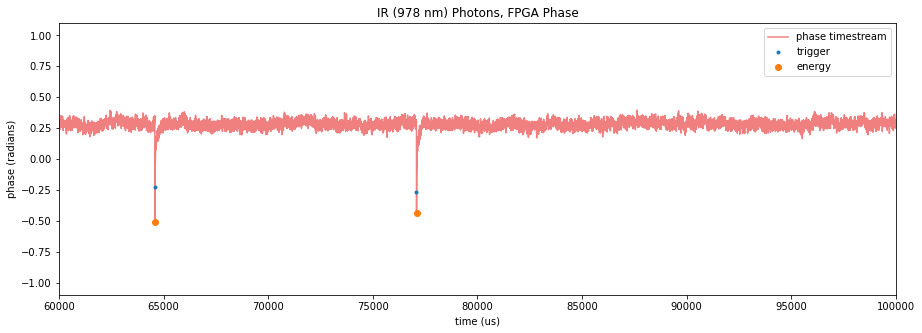

In [10]:
ir_phase_readout.plot_triggers(ir_phase, fs=1e6, energies=True, color='lightcoral')
plt.xlim([60000,100000]);
plt.title('IR (978 nm) Photons, FPGA Phase');

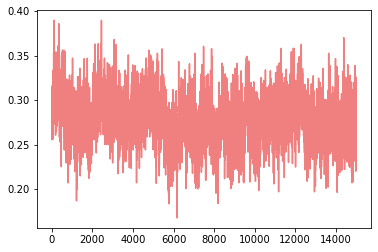

In [55]:
x = slice(35000, 50000)
plt.plot(ir_phase[x], color='lightcoral')
ir_phase_dark_mean = ir_phase[x].mean()

#### Phase Histogram

Max Phase: -0.7316107617977926 FWHM: 0.07512189441577444 radians


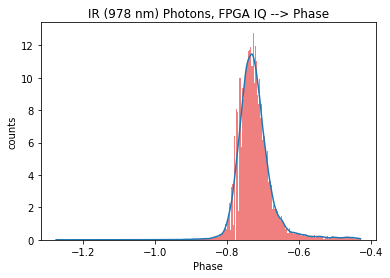

In [65]:
ir_phase_max_location, ir_phase_fwhm = compute_r(ir_phase_readout.photon_energies - ir_phase_dark_mean, color='lightcoral', plot=True)
print(f'Max Phase: {-ir_phase_max_location} FWHM: {ir_phase_fwhm} radians')
plt.title('IR (978 nm) Photons, FPGA IQ --> Phase');

### FPGA IQ --> Phase

#### Set Threshold and Deadtime

In [12]:
ir_iq_readout = MKIDReadout()
ir_iq_phase = np.angle(ir_iq)
ir_iq_readout.trigger(ir_iq_phase, fs = 1e6, threshold=0.35, deadtime=60)
print(f'Total photons: {(ir_iq_readout.trig>0).sum()}')

Total photons: 15457


#### Triggered Phase Timestream

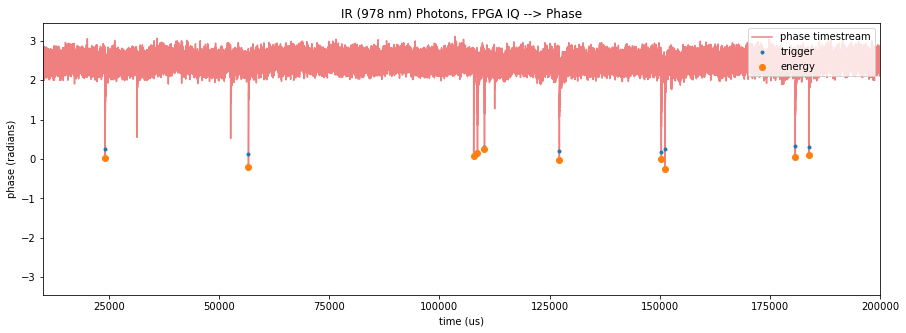

In [13]:
ir_iq_readout.plot_triggers(ir_iq_phase, fs=1e6, energies=True, color='lightcoral')
plt.xlim([10000,200000]);
plt.title('IR (978 nm) Photons, FPGA IQ --> Phase');

### Get Dark Level

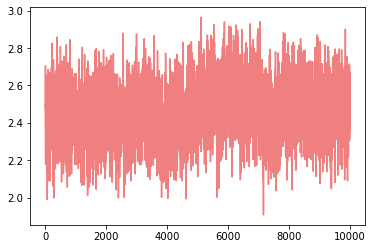

In [57]:
x = slice(10000, 20000)
plt.plot(ir_iq_phase[x], color='lightcoral')
ir_iq_dark_mean = ir_iq_phase[x].mean()

#### Phase Histogram

Max Phase: -2.4916388373005 FWHM: 0.3110142975006749 radians


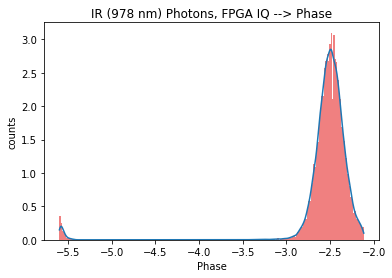

In [64]:
ir_iq_max_location, ir_iq_fwhm = compute_r(ir_iq_readout.photon_energies - ir_iq_dark_mean, color='lightcoral', plot=True)
print(f'Max Phase: {-ir_iq_max_location} FWHM: {ir_iq_fwhm} radians')
plt.title('IR (978 nm) Photons, FPGA IQ --> Phase');

## Blue Data

### FPGA Phase

#### Set Threshold and Deadtime

In [15]:
blue_phase_readout = MKIDReadout()
blue_phase_readout.trigger(blue_phase, fs = 1e6, threshold=-0.25, deadtime=30)
print(f'Total photons: {(blue_phase_readout.trig>0).sum()}')

Total photons: 22271


#### Triggered Phase Timestream

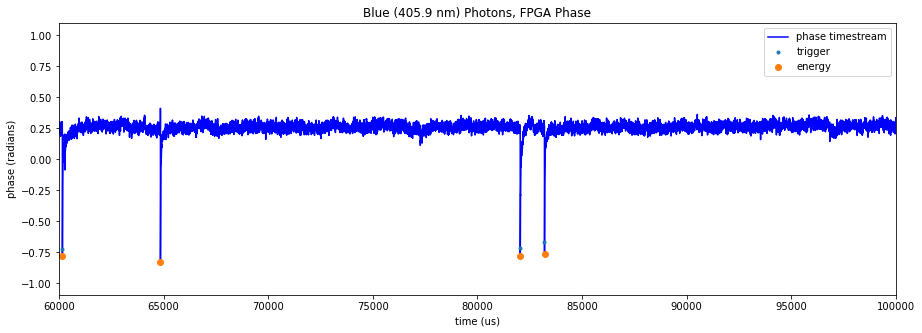

In [16]:
blue_phase_readout.plot_triggers(blue_phase, fs=1e6, energies=True, color='blue')
plt.xlim([60000,100000]);
plt.title('Blue (405.9 nm) Photons, FPGA Phase');

### Get Dark Level

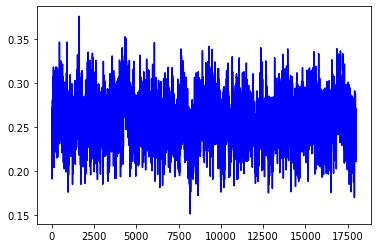

In [58]:
x = slice(42000, 60000)
plt.plot(blue_phase[x],color='blue')
blue_phase_dark_mean = blue_phase[x].mean()

#### Phase Histogram

Max Phase: -1.0412828326063976 FWHM: 0.0429828876170506 radians


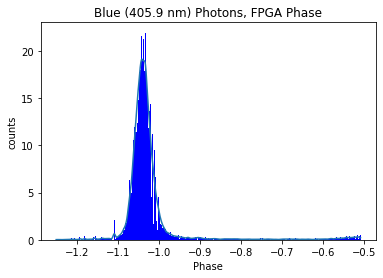

In [63]:
blue_phase_max_location, blue_phase_fwhm = compute_r(blue_phase_readout.photon_energies - blue_phase_dark_mean, color='blue', plot=True)
print(f'Max Phase: {-blue_phase_max_location} FWHM: {blue_phase_fwhm} radians')
plt.title('Blue (405.9 nm) Photons, FPGA Phase');

### FPGA IQ --> Phase

#### Set Threshold and Deadtime

In [18]:
blue_iq_readout = MKIDReadout()
blue_iq_phase = np.angle(blue_iq)
blue_iq_readout.trigger(blue_iq_phase, fs = 1e6, threshold=0.25, deadtime=60)
print(f'Total photons: {(blue_iq_readout.trig>0).sum()}')

Total photons: 10778


#### Triggered Phase Timestream

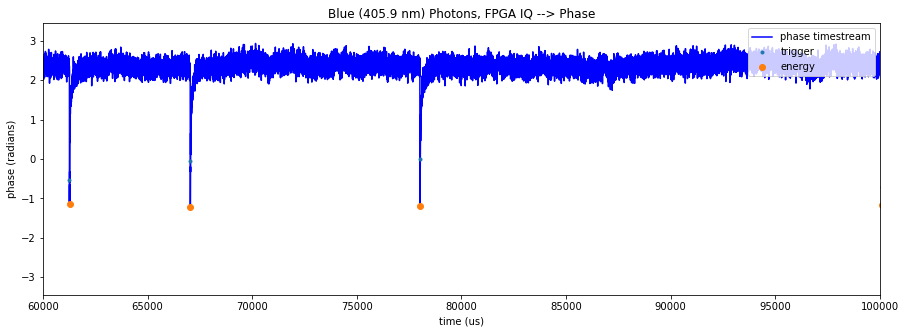

In [19]:
blue_iq_readout.plot_triggers(blue_iq_phase, fs=1e6, energies=True, color='blue')
plt.xlim([60000,100000]);
plt.title('Blue (405.9 nm) Photons, FPGA IQ --> Phase');

#### Get Dark Level

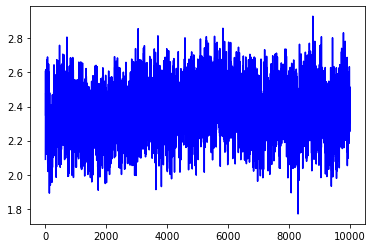

In [59]:
x = slice(10000, 20000)
plt.plot(blue_iq_phase[x], color='blue')
blue_iq_dark_mean = blue_iq_phase[x].mean()

#### Phase Histogram

Max Phase: -3.538689788252541 FWHM: 0.2451925343456014 radians


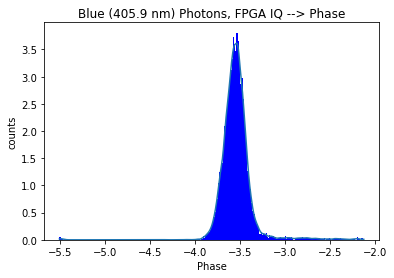

In [62]:
blue_iq_max_location, blue_iq_fwhm = compute_r(blue_iq_readout.photon_energies - blue_iq_dark_mean, color='blue', plot=True)
print(f'Max Phase: {-blue_iq_max_location} FWHM: {blue_iq_fwhm} radians')
plt.title('Blue (405.9 nm) Photons, FPGA IQ --> Phase');

### TRAsh

In [61]:
blue_phase_centered = blue_iq_readout.photon_energies - blue_phase_dark_mean
red_phase_centered = red_iq_readout.photon_energies - red_phase_dark_mean
ir_phase_centered = ir_iq_readout.photon_energies - ir_phase_dark_mean

# Dirty R

In [22]:
lasers = np.array([405.9, 663.1, 978.0])

## Phase Data

In [73]:
phase_dist_centers = -np.array([blue_phase_max_location, red_phase_max_location, ir_phase_max_location])
phase_dist_fwhm = np.array([blue_phase_fwhm, red_phase_fwhm, ir_phase_fwhm])

dldp = np.diff(lasers)/np.diff(phase_dist_centers)
dl = dldp.mean()*phase_dist_fwhm
dldp,dldp.mean(), lasers, phase_dist_centers, dl, lasers/dl

(array([1616.13911977, 2091.97855636]),
 1854.0588380636696,
 array([405.9, 663.1, 978. ]),
 array([-1.04128283, -0.88213812, -0.73161076]),
 array([ 79.69280267, 112.991332  , 139.28041227]),
 array([5.09330813, 5.86859176, 7.02180575]))

Distribution Centers: [-1.04128283 -0.88213812 -0.73161076]
Distribution FWHMs: [0.04298289 0.06094269 0.07512189]


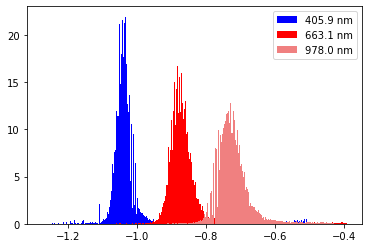

In [80]:
plt.figure()
plt.hist(blue_phase_readout.photon_energies - blue_phase_dark_mean, bins='auto', density=True, color='blue', label='405.9 nm');
plt.hist(red_phase_readout.photon_energies - red_phase_dark_mean, bins='auto', density=True, color='red', label='663.1 nm');
plt.hist(ir_phase_readout.photon_energies - ir_phase_dark_mean, bins='auto', density=True, color='lightcoral', label='978.0 nm');
plt.legend(loc='upper right')
print(f'Distribution Centers: {phase_dist_centers}')
print(f'Distribution FWHMs: {phase_dist_fwhm}')



In [72]:
phase_dist_centers

array([1.04128283, 0.88213812, 0.73161076])

In [ ]:
ir=ir_readout.photon_energies-ir_phase_dark_mean
blu=blue_readout.photon_energies-blue_phase_dark_mean
blu=blu[blu<-.9]
red=red_readout.photon_energies-red_phase_dark_mean
ir.mean(),ir.std(),blu.mean(),blu.std(),red.mean(),red.std()

irl=978.0
blul=405.9
redl=663.1
l=np.array([blul,redl,irl])


p=np.array([blu.mean(),red.mean(),ir.mean()])
fw=2*np.sqrt(2*np.log(2))*np.array([blu.std(),red.std(),ir.std()])


dldp=np.diff(l)/np.diff(p)
dl=dldp.mean()*fw
dldp,dldp.mean(), l, p, dl, l/dl